# Analisis Permintaan, Elastisitas Harga, dan Perencanaan Persediaan
Laporan ini menyajikan:
- Pembersihan dan kualitas data harian (penjualan, stok, harga)
- Estimasi elastisitas harga (regresi OLS)
- Pembangunan model ML untuk forecasting permintaan
- Simulasi forecast ke depan dengan pembatasan stok (supply-constrained)
- Ketidakpastian (prediction interval)
- Analitik persediaan (DOH, Turnover, Reorder Point)

Tujuan utama: membantu pengambilan keputusan replenishment dengan memadukan forecasting permintaan dan metrik persediaan secara praktis.

## Data dan Asumsi
- Sumber data: file CSV harian dengan kolom minimal: date, sales, stock, price.
- Frekuensi data: harian (D). Nilai hilang/duplikat tanggal akan ditangani.
- Asumsi operasional:
  - lead time (LT) dan service level (SL) ditetapkan di bagian konfigurasi.
  - Skenario harga masa depan bisa "flat" (harga terakhir) atau "delta" linear.
  - Simulasi penjualan masa depan dibatasi ketersediaan stok.
  - Tidak ada promosi khusus atau perubahan eksternal di periode forecast.

In [6]:
# 0) Import, Konfigurasi, dan Utilitas

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta
from pathlib import Path

# Stats / Model
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
try:
    from sklearn.metrics import root_mean_squared_error as rmse_fn
    def RMSE(y_true, y_pred):
        return rmse_fn(y_true, y_pred)
except Exception:
    from sklearn.metrics import mean_squared_error
    def RMSE(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

# Konfigurasi global 
CSV_PATH = "cleaned_dataset_en.csv"    
FORECAST_HORIZON = 90                  # 30–90 hari
TEST_DAYS = 90                         # ukuran test terakhir (time-based)
LEAD_TIME_DAYS = 7                     # lead time hari
SERVICE_LEVEL = 0.95                   # target service level (0.90, 0.95, 0.99, ...)
Z_MAP = {0.90:1.28, 0.95:1.65, 0.97:1.88, 0.98:2.05, 0.99:2.33}
Z = Z_MAP.get(SERVICE_LEVEL, 1.65)

# Skenario harga masa depan
FUTURE_PRICE_SCENARIO = "flat"         # "flat" atau "delta"
FUTURE_PRICE_DELTA = 0.0               # jika "delta": perubahan absolut per hari

# Simulasi stok masa depan
ASSUME_INBOUND_FUTURE = 0.0            # inbound harian selama horizon (jika ada jadwal inbound, sesuaikan)
CAP_REALIZED_BY_STOCK = True           # realisasi penjualan = min(demand, stock tersedia)

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Metrik pembantu
def smape(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    return (np.mean(2*np.abs(y_pred - y_true) / np.where(denom==0, 1.0, denom))) * 100

def mase(y_true, y_pred, y_train, m=7):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)
    if len(y_train) <= m:
        m = 1
    d = np.mean(np.abs(y_train[m:] - y_train[:-m])) + 1e-8
    return np.mean(np.abs(y_true - y_pred)) / d

def print_env_info():
    import sklearn
    info = {
        "Python": sys.version.split()[0],
        "Platform": platform.platform(),
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "seaborn": sns.__version__,
        "statsmodels": sm.__version__,
        "scikit-learn": sklearn.__version__,
    }
    print("Environment info:")
    for k, v in info.items():
        print(f"  {k:>12}: {v}")

print_env_info()

Environment info:
        Python: 3.12.4
      Platform: Windows-11-10.0.22631-SP0
        pandas: 2.2.2
         numpy: 1.26.4
    matplotlib: 3.8.4
       seaborn: 0.13.2
   statsmodels: 0.14.2
  scikit-learn: 1.4.2


## 1) Load & Praproses Data
Langkah ini:
- Membaca CSV dan memastikan indeks waktu harian
- Menangani nilai hilang dan anomali dasar (mis. harga <= 0)
- Membuat fitur kalender dan estimasi inbound
- Menandai hari-hari low-stock (potensi censoring pada penjualan)



In [13]:
# 1) Load & Praproses Data

# Baca CSV
df = pd.read_csv(CSV_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').drop_duplicates('date').set_index('date')
df = df.asfreq('D')  # pastikan frekuensi harian

# Pastikan numeric
for c in ['sales','stock','price']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Perbaikan nilai
# Harga: <=0 atau NaN -> NaN lalu ffill/bfill/mean
df.loc[df['price']<=0, 'price'] = np.nan
df['price'] = df['price'].ffill().bfill()
if df['price'].isna().any():
    df['price'] = df['price'].fillna(df['price'].mean())

# Penjualan: NaN -> 0 (asumsi toko buka)
df['sales'] = df['sales'].fillna(0)

# Stok: ffill; bila awal NaN maka bfill
df['stock'] = df['stock'].ffill()
if df['stock'].isna().any():
    df['stock'] = df['stock'].fillna(method='bfill')

# Fitur kalender
df['dow'] = df.index.dayofweek
df['is_weekend'] = (df['dow']>=5).astype(int)
df['month'] = df.index.month

# Estimasi inbound & start-of-day stock
df['prev_stock'] = df['stock'].shift(1)
df['inbound'] = (df['stock'] - df['prev_stock'] + df['sales']).clip(lower=0).fillna(0)
df['start_stock'] = df['prev_stock'].fillna(df['stock'])

# Flag low stock (indikasi potensi censoring permintaan)
med7_sales = df['sales'].rolling(7, min_periods=1).median().clip(lower=1)
df['low_stock_flag'] = (df['stock'] < med7_sales).astype(int)

# Moving averages untuk EDA
df['sales_ma7'] = df['sales'].rolling(7, min_periods=1).mean()
df['sales_ma28'] = df['sales'].rolling(28, min_periods=1).mean()

# STL (opsional, untuk insight trend/seasonal mingguan)
try:
    stl = STL(df['sales'], period=7, robust=True).fit()
    df['stl_trend'] = stl.trend
    df['stl_seasonal'] = stl.seasonal
    df['stl_resid'] = stl.resid
except Exception:
    df['stl_trend'] = np.nan
    df['stl_seasonal'] = np.nan
    df['stl_resid'] = np.nan

# Transformasi log (untuk analisis elastisitas)
df['log_sales'] = np.log1p(df['sales'])
df['log_price'] = np.log(df['price'].clip(lower=1e-8))
df['dlog_sales'] = df['log_sales'].diff()
df['dlog_price'] = df['log_price'].diff()

print("Ringkasan data (5 baris terakhir):")
display(df.tail())

Ringkasan data (5 baris terakhir):


,sales,stock,price,dow,is_weekend,month,prev_stock,inbound,start_stock,low_stock_flag,sales_ma7,sales_ma28,stl_trend,stl_seasonal,stl_resid,log_sales,log_price,dlog_sales,dlog_price
date,,,,,,,,,,,,,,,,,,,
2016-07-27,98.0,3179.0,2.39,2,0,7,2893.0,384.0,2893.0,0,96.857143,164.500000,164.145141,161.822648,-227.967789,4.595120,0.871293,0.010152,0.0
2016-07-28,108.0,3071.0,2.39,3,0,7,3179.0,0.0,3179.0,0,103.714286,163.321429,168.845917,-77.269841,16.423924,4.691348,0.871293,0.096228,0.0
2016-07-29,128.0,4095.0,2.39,4,0,7,3071.0,1152.0,3071.0,0,108.000000,159.071429,173.956645,-45.595245,-0.361400,4.859812,0.871293,0.168465,0.0
2016-07-30,270.0,3825.0,2.39,5,1,7,4095.0,0.0,4095.0,0,127.571429,157.214286,179.398510,91.896985,-1.295495,5.602119,0.871293,0.742306,0.0
2016-07-31,183.0,3642.0,2.39,6,1,7,3825.0,0.0,3825.0,0,135.142857,156.750000,185.096695,-7.065732,4.969037,5.214936,0.871293,-0.387183,0.0


## 2) EDA Ringkas

- Korelasi sederhana harga vs penjualan
- Deteksi lonjakan penjualan (z-score)
- Visualisasi time-series dasar

Catatan: Korelasi sederhana bersifat indikatif; kausalitas tidak otomatis tersirat.

Korelasi sederhana price vs sales: 0.072
Korelasi Δlog(price) vs Δlog(sales): -0.090
Jumlah lonjakan terdeteksi (>2σ): 59


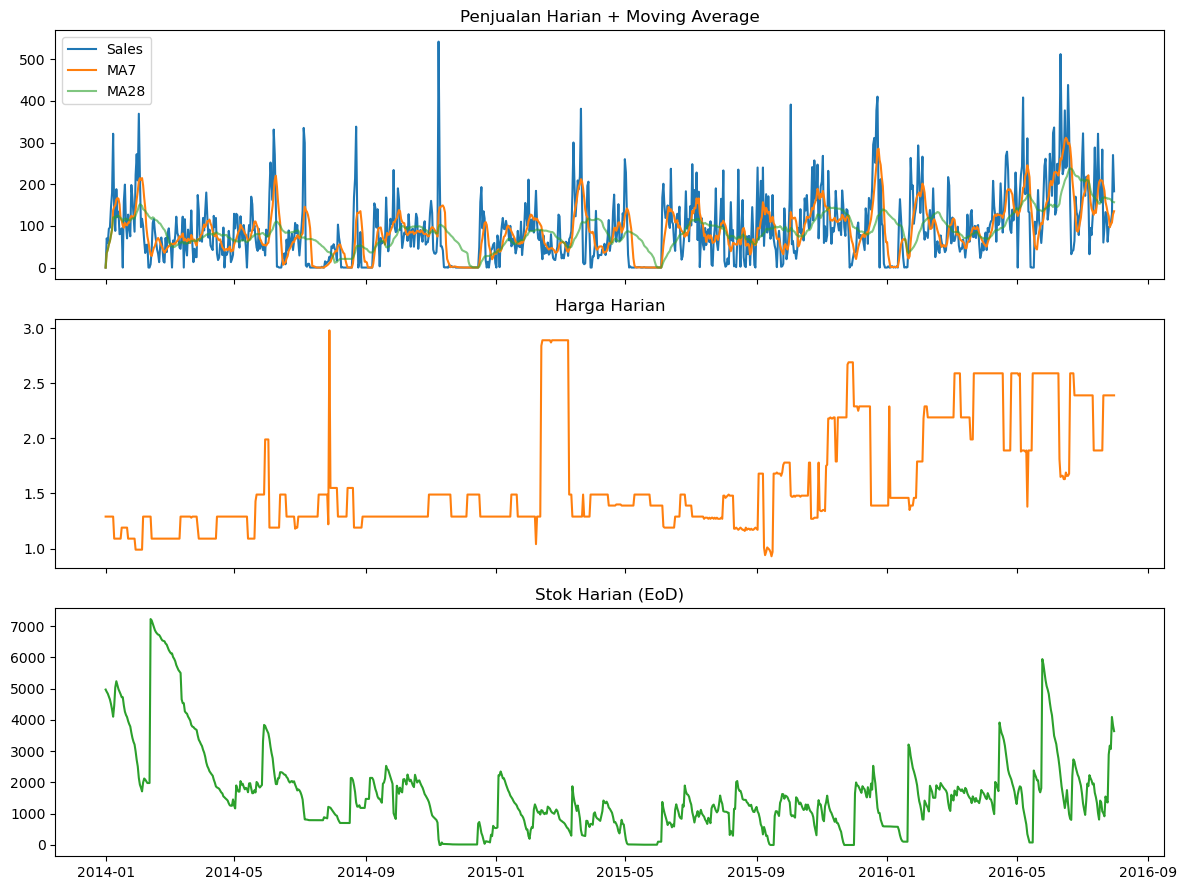

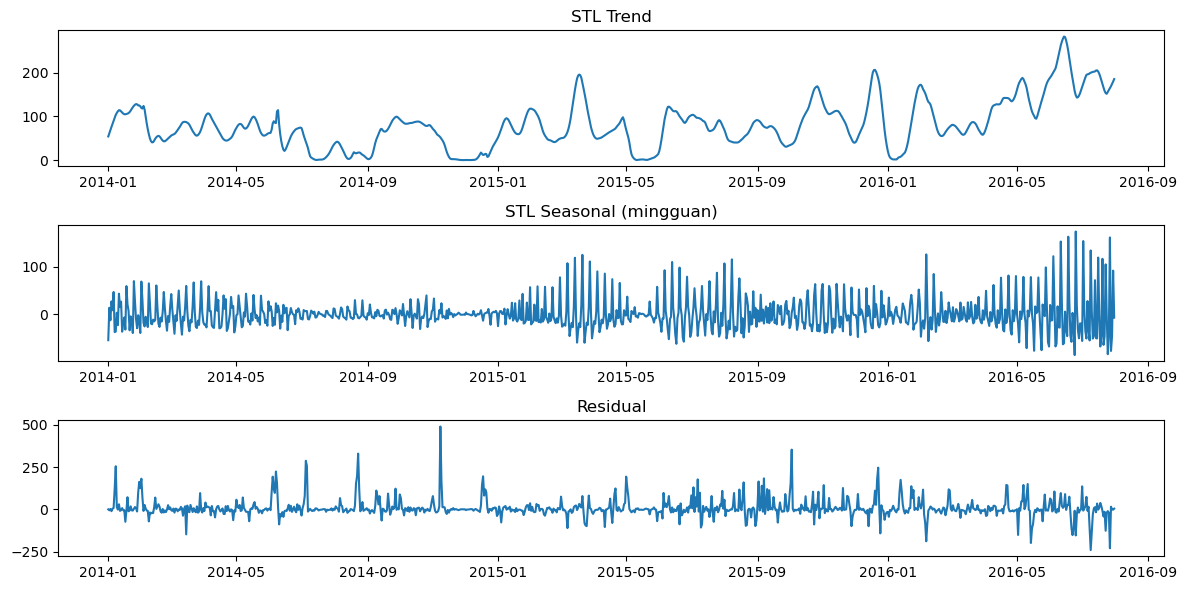

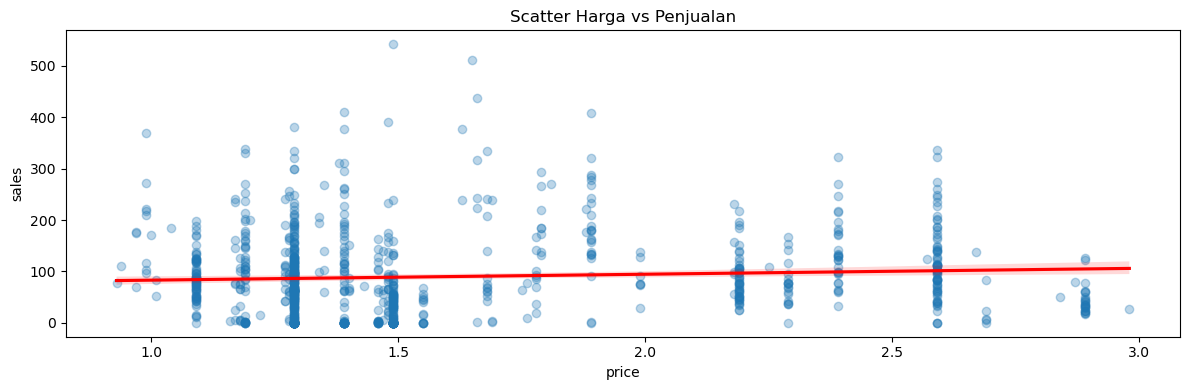

In [18]:
# 2) EDA Ringkas

# Korelasi linear dan dalam perbedaan log
corr_all = df[['price','sales']].corr().iloc[0,1]
corr_dlogs = df[['dlog_price','dlog_sales']].dropna().corr().iloc[0,1]
print(f"Korelasi sederhana price vs sales: {corr_all:.3f}")
print(f"Korelasi Δlog(price) vs Δlog(sales): {corr_dlogs:.3f}")

# Deteksi lonjakan
df['sales_z'] = (df['sales'] - df['sales'].rolling(28, min_periods=7).mean()) / (df['sales'].rolling(28, min_periods=7).std() + 1e-6)
spikes = df[df['sales_z']>2]
print(f"Jumlah lonjakan terdeteksi (>2σ): {len(spikes)}")

# Plot time-series
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)
axes[0].plot(df.index, df['sales'], label='Sales')
axes[0].plot(df.index, df['sales_ma7'], label='MA7')
axes[0].plot(df.index, df['sales_ma28'], label='MA28', alpha=0.6)
axes[0].set_title('Penjualan Harian + Moving Average'); axes[0].legend()

axes[1].plot(df.index, df['price'], color='tab:orange'); axes[1].set_title('Harga Harian')

axes[2].plot(df.index, df['stock'], color='tab:green'); axes[2].set_title('Stok Harian (EoD)')
plt.tight_layout(); plt.show()

# Plot STL (jika tersedia)
if df['stl_trend'].notna().any():
    plt.figure(figsize=(12,6))
    plt.subplot(3,1,1); plt.plot(df.index, df['stl_trend']); plt.title('STL Trend')
    plt.subplot(3,1,2); plt.plot(df.index, df['stl_seasonal']); plt.title('STL Seasonal (mingguan)')
    plt.subplot(3,1,3); plt.plot(df.index, df['stl_resid']); plt.title('Residual')
    plt.tight_layout(); plt.show()

# Scatter price vs sales
plt.figure(figsize=(12,4))
plt.scatter(df['price'], df['sales'], alpha=0.3)
sns.regplot(x='price', y='sales', data=df, scatter=False, color='red')
plt.title('Scatter Harga vs Penjualan')
plt.tight_layout(); plt.show()

### Analisis Awal: Hubungan Harga dan Penjualan

Pada tahap *Exploratory Data Analysis* (EDA) ringkas, kami menemukan tiga karakteristik utama dari data yang akan memandu proses pemodelan selanjutnya.

* **Korelasi Sederhana (`price` vs `sales`): 0.072**
    Korelasi sederhana antara harga dan penjualan menunjukkan hubungan positif yang sangat lemah. Hasil ini **bertentangan dengan teori ekonomi** dan kemungkinan besar merupakan **korelasi palsu (*spurious correlation*)**. Hal ini bisa disebabkan oleh faktor lain seperti tren waktu (inflasi) atau musiman, di mana harga dan penjualan sama-sama naik seiring waktu. Oleh karena itu, korelasi sederhana ini dianggap **tidak andal** untuk mengukur elastisitas harga.

* **Korelasi Perubahan Harian (`Δlog(price)` vs `Δlog(sales)`): -0.090**
    Untuk mendapatkan gambaran yang lebih akurat, kami mengukur korelasi antara *perubahan persentase harian* pada harga dan penjualan. Hasilnya menunjukkan **korelasi negatif yang lemah (-0.090)**. Meskipun nilainya kecil, arahnya (negatif) **sesuai dengan logika ekonomi**: kenaikan harga harian cenderung diikuti oleh penurunan penjualan harian. Ini adalah indikator yang jauh lebih baik untuk elastisitas harga daripada korelasi sederhana.

* **Jumlah Lonjakan Penjualan Terdeteksi: 59**
    Analisis menemukan **59 titik data** di mana penjualan melonjak secara tidak biasa (di atas 2 standar deviasi dari rata-rata). Hal ini mengindikasikan bahwa data penjualan memiliki **volatilitas yang tinggi** dan sering mengalami anomali atau *outlier*. Keberadaan lonjakan ini sangat penting untuk diperhatikan dalam tahap *feature engineering* dan pemodelan agar tidak mengganggu akurasi prediksi. dengan baik.

## 3) Estimasi Elastisitas Harga
Kita estimasi respons penjualan terhadap perubahan harga:
- Model baseline: OLS log-log dengan kontrol DOW, bulan, dan stok awal, hanya pada hari non-low-stock.
- Spesifikasi alternatif:
  - Spec A: filter high-stock + fixed effects Year-Month
  - Spec B: First-difference (Δlog), menangkap elastisitas jangka prapkan).

In [21]:
# 3) Estimasi Elastisitas Harga

# Baseline OLS log-log
reg = df.copy().dropna(subset=['log_sales','log_price'])
reg_elast = reg[reg['low_stock_flag']==0].copy()

try:
    dow_dum = pd.get_dummies(reg_elast['dow'], prefix='dow', drop_first=True)
    mon_dum = pd.get_dummies(reg_elast['month'], prefix='m', drop_first=True)
    X_base = pd.concat([
        reg_elast[['log_price']].astype(float),
        dow_dum.astype(float),
        mon_dum.astype(float),
        np.log1p(reg_elast[['start_stock']]).rename(columns={'start_stock':'log_start_stock'})
    ], axis=1)
    X_base = sm.add_constant(X_base)
    y_base = reg_elast['log_sales'].astype(float)

    if len(X_base) >= 10:
        ols_model = sm.OLS(y_base, X_base).fit(cov_type='HC1')
        display(ols_model.summary())
        elast_base = ols_model.params.get('log_price', np.nan)
        print(f"Estimasi elastisitas (Baseline OLS log-log): {elast_base:.3f} (negatif = penjualan turun saat harga naik)")
    else:
        print("Data tidak cukup untuk OLS baseline.")
except Exception as e:
    print("OLS baseline gagal:", e)

# Spec A: High-Stock + YM FE
reg0 = df.copy().dropna(subset=['log_sales','log_price','start_stock'])
reg0['med7'] = reg0['sales'].rolling(7, min_periods=3).median()
median_for_thr = reg0['med7'].median() if reg0['med7'].notna().any() else 1.0
reg_hs = reg0[ reg0['start_stock'] >= 1.5 * reg0['med7'].fillna(median_for_thr) ].copy()
reg_hs['ym'] = reg_hs.index.to_period('M')

if len(reg_hs) > 30:
    try:
        X_A = pd.concat([
            reg_hs[['log_price']].astype(float),
            pd.get_dummies(reg_hs['dow'], prefix='dow', drop_first=True).astype(float),
            pd.get_dummies(reg_hs['ym'], prefix='ym', drop_first=True).astype(float),
            np.log1p(reg_hs[['start_stock']]).rename(columns={'start_stock':'log_start_stock'})
        ], axis=1)
        X_A = sm.add_constant(X_A)
        y_A = reg_hs['log_sales'].astype(float)
        ols_A = sm.OLS(y_A, X_A).fit(cov_type='HC1')
        display(ols_A.summary())
        elast_A = ols_A.params.get('log_price', np.nan)
        print(f"Estimasi elastisitas (Spec A - HighStock + YM FE): {elast_A:.3f}")
    except Exception as e:
        print("Spec A gagal:", e)
else:
    print("Spec A dilewati (data high-stock tidak cukup).")

# Spec B: First-Difference
reg_fd = reg0.copy()
reg_fd['dlog_sales'] = reg_fd['log_sales'].diff()
reg_fd['dlog_price'] = reg_fd['log_price'].diff()
reg_fd['dlog_stock'] = np.log1p(reg_fd['start_stock']).diff()
reg_fd = reg_fd.dropna(subset=['dlog_sales','dlog_price'])
if len(reg_fd) >= 10:
    try:
        X_B = pd.concat([
            reg_fd[['dlog_price','dlog_stock']].astype(float),
            pd.get_dummies(reg_fd['dow'], prefix='dow', drop_first=True).astype(float)
        ], axis=1)
        X_B = sm.add_constant(X_B)
        y_B = reg_fd['dlog_sales'].astype(float)
        ols_B = sm.OLS(y_B, X_B).fit(cov_type='HC1')
        display(ols_B.summary())
        elast_B = ols_B.params.get('dlog_price', np.nan)
        print(f"Estimasi elastisitas (Spec B - First-Diff short-run): {elast_B:.3f}")
    except Exception as e:
        print("Spec B gagal:", e)
else:
    print("Spec B dilewati (data tidak cukup).")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     27.93
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           3.17e-77
Time:                        14:17:39   Log-Likelihood:                -1558.0
No. Observations:                 909   AIC:                             3156.
Df Residuals:                     889   BIC:                             3252.
Df Model:                          19                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.7883      0.410     -4.366      0.000      -2.591      -0.986
log_price           0.6345      0.138      4.608      0.000       0.365       0.904
dow_1              -0.0293      0.169     -0.173      0.863      -0.361       0.303
dow_2               0.2863      0.165      1.738      0.082      -0.037       0.609
dow_3               0.1362      0.162      0.843      0.399      -0.181       0.453
dow_4               0.3085      0.171      1.802      0.072      -0.027       0.644
dow_5               0.6757      0.171      3.950      0.000       0.340       1.011
dow_6               0.3193      0.160      1.995      0.046       0.006       0.633
m_2                 0.0163      0.212      0.077      0.939      -0.399       0.432
m_3                 0.0263      0.214      0.123      0.902      -0.393       0.445
m_4                 0.3601      0.183      1.965      0.049       0.001       0.719
m_5                 0.1916      0.218      0.877      0.380      -0.237       0.620
m_6                 0.3915      0.222      1.765      0.078      -0.043       0.826
m_7                -0.0240      0.246     -0.098      0.922      -0.506       0.458
m_8                -0.9407      0.293     -3.210      0.001      -1.515      -0.366
m_9                 0.0444      0.315      0.141      0.888      -0.574       0.663
m_10                0.7702      0.181      4.263      0.000       0.416       1.124
m_11                0.6534      0.247      2.645      0.008       0.169       1.138
m_12                0.2862      0.265      1.081      0.280      -0.233       0.805
log_start_stock     0.7059      0.050     14.093      0.000       0.608       0.804
==============================================================================
Omnibus:                      131.798   Durbin-Watson:                   0.776
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              245.662
Skew:                          -0.881   Prob(JB):                     4.52e-54
Kurtosis:                       4.840   Cond. No.                         86.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Estimasi elastisitas (Baseline OLS log-log): 0.635 (negatif = penjualan turun saat harga naik)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     82.54
Date:                Mon, 15 Sep 2025   Prob (F-statistic):          3.86e-259
Time:                        14:17:39   Log-Likelihood:                -1409.3
No. Observations:                 908   AIC:                             2897.
Df Residuals:                     869   BIC:                             3084.
Df Model:                          38                                         
Covariance Type:                  HC1                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.7415      0.557     -6.716      0.000      -4.833      -2.650
log_price          -1.6765      0.234     -7.153      0.000      -2.136      -1.217
dow_1              -0.0959      0.145     -0.661      0.508      -0.380       0.188
dow_2               0.2094      0.141      1.489      0.137      -0.066       0.485
dow_3               0.0911      0.144      0.634      0.526      -0.190       0.373
dow_4               0.2135      0.149      1.435      0.151      -0.078       0.505
dow_5               0.6157      0.147      4.196      0.000       0.328       0.903
dow_6               0.3113      0.139      2.247      0.025       0.040       0.583
ym_2014-02         -0.7444      0.335     -2.221      0.026      -1.401      -0.087
ym_2014-03         -0.6561      0.319     -2.054      0.040      -1.282      -0.030
ym_2014-04          0.2396      0.275      0.870      0.384      -0.300       0.779
ym_2014-05          0.7205      0.287      2.507      0.012       0.157       1.284
ym_2014-06          0.0079      0.380      0.021      0.984      -0.738       0.753
ym_2014-07         -0.8345      0.409     -2.041      0.041      -1.636      -0.033
ym_2014-08         -0.7891      0.452     -1.746      0.081      -1.675       0.097
ym_2014-09         -0.0392      0.439     -0.089      0.929      -0.899       0.820
ym_2014-10          0.9466      0.254      3.727      0.000       0.449       1.444
ym_2014-11          1.7684      0.400      4.418      0.000       0.984       2.553
ym_2014-12          1.6497      0.408      4.040      0.000       0.849       2.450
ym_2015-01          1.0465      0.325      3.217      0.001       0.409       1.684
ym_2015-02          2.0855      0.324      6.430      0.000       1.450       2.721
ym_2015-03          2.0275      0.364      5.577      0.000       1.315       2.740
ym_2015-04          1.5593      0.290      5.368      0.000       0.990       2.129
ym_2015-05          1.9572      0.451      4.344      0.000       1.074       2.840
ym_2015-06          1.5786      0.293      5.384      0.000       1.004       2.153
ym_2015-07          1.3737      0.313      4.386      0.000       0.760       1.988
ym_2015-08          0.1320      0.386      0.342      0.732      -0.624       0.888
ym_2015-09          1.4499      0.402      3.606      0.000       0.662       2.238
ym_2015-10          1.9185      0.288      6.656      0.000       1.354       2.483
ym_2015-11          2.6858      0.324      8.299      0.000       2.051       3.320
ym_2015-12          1.5276      0.399      3.829      0.000       0.746       2.309
ym_2016-01          0.5612      0.425      1.320      0.187      -0.272       1.395
ym_2016-02          2.0107      0.322      6.240      0.000       1.379       2.642
ym_2016-03          1.8794      0.320      5.864      0.000

Estimasi elastisitas (Spec A - HighStock + YM FE): -1.677


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             dlog_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.810
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           3.75e-13
Time:                        14:17:40   Log-Likelihood:                -1457.7
No. Observations:                 942   AIC:                             2933.
Df Residuals:                     933   BIC:                             2977.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3259      0.108     -3.013      0.003      -0.538      -0.114
dlog_price    -1.0783      0.354     -3.044      0.002      -1.773      -0.384
dlog_stock     0.2350      0.104      2.264      0.024       0.032       0.438
dow_1          0.2685      0.160      1.681      0.093      -0.045       0.582
dow_2          0.7007      0.140      5.020      0.000       0.427       0.974
dow_3          0.1899      0.140      1.357      0.175      -0.084       0.464
dow_4          0.4381      0.152      2.890      0.004       0.141       0.735
dow_5          0.6965      0.145      4.819      0.000       0.413       0.980
dow_6          0.0311      0.135      0.230      0.818      -0.234       0.296
==============================================================================
Omnibus:                      143.029   Durbin-Watson:                   2.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1980.304
Skew:                           0.032   Prob(JB):                         0.00
Kurtosis:                      10.103   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

Estimasi elastisitas (Spec B - First-Diff short-run): -1.078


#### Model 1: Baseline OLS (log-log)
Ini adalah model dasar yang hanya menyertakan variabel harga, efek hari (`dow`), dan bulan (`m`).

* **Estimasi Elastisitas:** **`+0.635`**
* **Analisis:** Model ini memberikan hasil yang **tidak logis secara ekonomi**. Koefisien positif yang signifikan secara statistik menunjukkan bahwa kenaikan harga justru akan *meningkatkan* penjualan. Ini adalah tanda bahwa model ini memiliki **spesifikasi yang keliru** dan gagal mengisolasi efek harga dari tren waktu atau faktor lainnya.
* **Putusan:** Model ini tidak dapat diandalkan dan hasilnya diabaikan.

#### Model 2: Spec A - HighStock + Year-Month Fixed Effects (FE)
Model ini merupakan perbaikan signifikan dengan menggunakan kontrol waktu yang lebih detail (`Year-Month FE`) untuk menangkap tren dan musiman secara lebih baik.

* **Estimasi Elastisitas:** **`-1.677`**
* **Analisis:** Hasil ini **sangat logis dan kuat**. Koefisien negatif menunjukkan bahwa **kenaikan harga 1% akan menurunkan penjualan sekitar 1.68%**. Karena nilai absolutnya lebih besar dari 1, ini mengindikasikan bahwa permintaan bersifat **elastis**. Konsumen sangat responsif terhadap perubahan harga. Model ini juga memiliki `R-squared` yang lebih tinggi (`0.551`), menunjukkan kemampuan jelas yang lebih baik.
* **Putusan:** Ini adalah estimasi elastisitas utama yang paling dapat dipercaya dari analisis ini.

#### Model 3: Spec B - First-Difference (Short-Run)
Model ini mengukur dampak **jangka pendek (harian)** dari perubahan harga terhadap perubahan penjualan.

* **Estimasi Elastisitas:** **`-1.078`**
* **Analisis:** Model ini mengonfirmasi arah hubungan yang negatif. Nilainya yang mendekati -1 mengindikasikan permintaan bersifat **unit elastis** dalam jangka pendek. Artinya, dalam respons harian, penurunan penjualan hampir sebanding dengan kenaikan harga.
* **Putusan:** Memberikan bukti pendukung yang kuat dan wawasan tentang respons pasar yang cepat.

## 4) Fitur untuk Model Forecasting
Kita membangun fitur time-series:
- Lags penjualan: 1, 7, 14, 28 (disesuaikan otomatis jika histori pendek)
- Moving average berbasis lag: MA7, MA28
- Harga dan perubahan harga, kalender (DOW, bulan)
- Stok (log) dan inboundcasting.


In [24]:
# 4) Fitur untuk Model Forecasting

# Lag disesuaikan panjang histori
BASE_LAGS = [1, 7, 14, 28]
AVAILABLE_LAGS = [l for l in BASE_LAGS if l <= max(1, len(df)-1)]
if len(AVAILABLE_LAGS) == 0 and len(df) > 1:
    AVAILABLE_LAGS = [1]
MA_WINDOWS = [7, 28]

def make_features(frame: pd.DataFrame) -> pd.DataFrame:
    """
    Bangun fitur untuk model ML dari frame dengan indeks harian:
    - Lags penjualan, moving averages berbasis lag
    - Harga (log, pct change), kalender
    - Log stok dan inbound flag

    Drop hanya berdasarkan kolom fitur inti (bukan target 'sales').
    """
    f = frame.copy()

    # Lags penjualan
    for lag in AVAILABLE_LAGS:
        f[f'sales_lag{lag}'] = f['sales'].shift(lag)

    # MA berbasis lag (gunakan shift(1) agar tidak pakai sales hari-ini)
    for win in MA_WINDOWS:
        f[f'sales_ma{win}'] = f['sales'].shift(1).rolling(win, min_periods=1).mean()

    # Harga dan perubahan harga
    f['price_change'] = f['price'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    f['log_price'] = np.log(f['price'].clip(lower=1e-8))

    # Kalender
    f['dow'] = f.index.dayofweek
    f['is_weekend'] = (f['dow']>=5).astype(int)
    f['month'] = f.index.month

    # Stok dan inbound
    f['log_stock'] = np.log1p(f['stock'])
    f['inbound_flag'] = (f['inbound']>0).astype(int)

    # Kolom fitur wajib tidak NaN
    feature_cols = [f'sales_lag{lag}' for lag in AVAILABLE_LAGS] + \
                   [f'sales_ma{win}' for win in MA_WINDOWS] + \
                   ['price','log_price','price_change','log_stock','is_weekend','inbound_flag','dow','month']

    f = f.dropna(subset=feature_cols)

    return f

# Buat dataset fitur historis
feat = make_features(df)

# Daftar kolom fitur numerik dan kategori
num_cols = [f'sales_lag{lag}' for lag in AVAILABLE_LAGS] + \
           [f'sales_ma{win}' for win in MA_WINDOWS] + \
           ['price','log_price','price_change','log_stock','is_weekend','inbound_flag']
cat_cols = ['dow','month']
target_col = 'sales'

print("Dimensi fitur historis:", feat.shape)
display(feat.tail())

Dimensi fitur historis: (915, 27)


,sales,stock,price,dow,is_weekend,month,prev_stock,inbound,start_stock,low_stock_flag,...,dlog_sales,dlog_price,sales_z,sales_lag1,sales_lag7,sales_lag14,sales_lag28,price_change,log_stock,inbound_flag
date,,,,,,,,,,,,,,,,,,,,,
2016-07-27,98.0,3179.0,2.39,2,0,7,2893.0,384.0,2893.0,0,...,0.010152,0.0,-0.851288,97.0,283.0,288.0,130.0,0.0,8.064636,1
2016-07-28,108.0,3071.0,2.39,3,0,7,3179.0,0.0,3179.0,0,...,0.096228,0.0,-0.702662,98.0,60.0,138.0,141.0,0.0,8.030084,0
2016-07-29,128.0,4095.0,2.39,4,0,7,3071.0,1152.0,3071.0,0,...,0.168465,0.0,-0.402247,108.0,98.0,189.0,247.0,0.0,8.317766,1
2016-07-30,270.0,3825.0,2.39,5,1,7,4095.0,0.0,4095.0,0,...,0.742306,0.0,1.529766,128.0,133.0,321.0,322.0,0.0,8.249575,0
2016-07-31,183.0,3642.0,2.39,6,1,7,3825.0,0.0,3825.0,0,...,-0.387183,0.0,0.357071,270.0,130.0,209.0,196.0,0.0,8.200563,0


#### Hasil Tabel Fitur

Proses di atas menghasilkan sebuah tabel fitur (matriks) dengan dimensi `(915, 27)`. Artinya, kita memiliki **915 sampel (hari)** yang siap digunakan untuk melatih model, dengan masing-masing sampel memiliki **27 fitur** sebagai prediktor. Cuplikan tabel di atas menunjukkan bagaimana data mentah kini telah diperkaya dengan berbagai fitur informatif yang siap untuk tahap pemodelan.

## 5) Model, Validasi, dan Evaluasi
- Model: HistGradientBoostingRegressor dalam pipeline (scaling numerik + OHE kategori)
- Validasi: holdout time-based (N hari terakhir sebagai test)
- Metrik: RMSE, MAE, sMAPE, MASE
- Pembanding: baseline naive-7 (seasonal nakecil.


[VALIDASI 90 hari] RMSE=82.84 | MAE=59.91 | sMAPE=43.81% | MASE=0.97
[Baseline Naive-7]       RMSE=129.10 | MAE=104.70 | sMAPE=71.01% | MASE=1.69


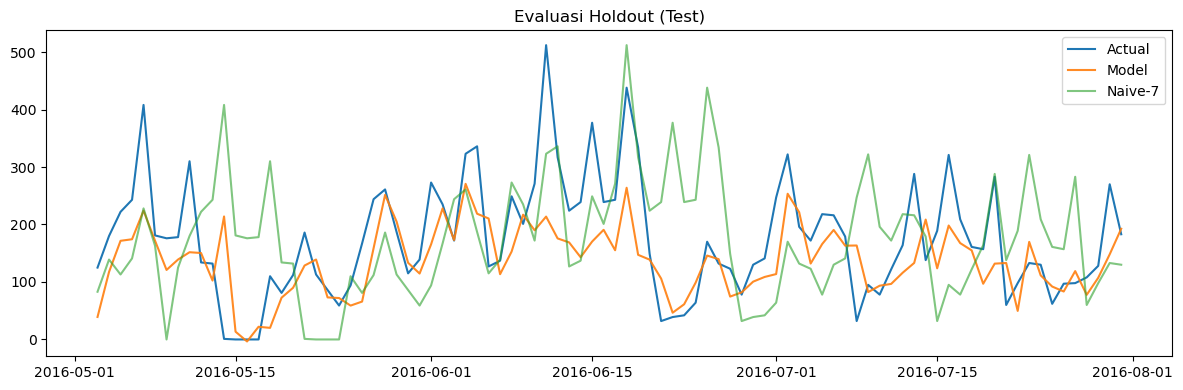

In [27]:
# 5) Model, Validasi, dan Evaluasi

# OneHotEncoder kompatibel lintas versi sklearn
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', ohe, cat_cols)
])

model = HistGradientBoostingRegressor(
    loss='squared_error',
    max_depth=6,
    learning_rate=0.05,
    max_leaf_nodes=31,
    random_state=RANDOM_STATE
)

pipe = Pipeline([('pre', pre), ('model', model)])

# Split train/test time-based
TEST_DAYS_ACT = TEST_DAYS
if len(feat) <= TEST_DAYS + 30:
    TEST_DAYS_ACT = max(14, len(feat)//5)  # fallback jika data pendek

if len(feat) < 30 or TEST_DAYS_ACT < 7:
    print(f"Peringatan: data fitur pendek (n={len(feat)}). Hasil evaluasi bisa kurang stabil.")

train = feat.iloc[:-TEST_DAYS_ACT] if TEST_DAYS_ACT>0 and len(feat)>TEST_DAYS_ACT else feat.copy()
test = feat.iloc[-TEST_DAYS_ACT:] if TEST_DAYS_ACT>0 and len(feat)>TEST_DAYS_ACT else feat.iloc[0:0]

X_train = train[num_cols+cat_cols]
y_train = train[target_col]

pipe.fit(X_train, y_train)

if len(test) > 0:
    X_test = test[num_cols+cat_cols]
    y_test = test[target_col]
    pred_test = pipe.predict(X_test)

    # Baseline naive-7
    y_test_baseline = feat['sales'].shift(7).reindex(y_test.index)

    # Align mask
    mask = (~y_test.isna())
    mask &= (~pd.Series(pred_test, index=y_test.index).isna())
    mask &= (~y_test_baseline.isna())

    y_true_eval = y_test[mask]
    y_pred_eval = pd.Series(pred_test, index=y_test.index)[mask]
    y_base_eval = y_test_baseline[mask]

    rmse_model = RMSE(y_true_eval, y_pred_eval)
    mae_model = mean_absolute_error(y_true_eval, y_pred_eval)
    smape_model = smape(y_true_eval, y_pred_eval)
    mase_model = mase(y_true_eval, y_pred_eval, y_train.values, m=7)

    rmse_base = RMSE(y_true_eval, y_base_eval)
    mae_base = mean_absolute_error(y_true_eval, y_base_eval)
    smape_base = smape(y_true_eval, y_base_eval)
    mase_base = mase(y_true_eval, y_base_eval, y_train.values, m=7)

    print(f"[VALIDASI {len(y_true_eval)} hari] RMSE={rmse_model:.2f} | MAE={mae_model:.2f} | sMAPE={smape_model:.2f}% | MASE={mase_model:.2f}")
    print(f"[Baseline Naive-7]       RMSE={rmse_base:.2f} | MAE={mae_base:.2f} | sMAPE={smape_base:.2f}% | MASE={mase_base:.2f}")

    # Plot aktual vs prediksi (test)
    plt.figure(figsize=(12,4))
    plt.plot(y_true_eval.index, y_true_eval, label='Actual')
    plt.plot(y_true_eval.index, y_pred_eval, label='Model', alpha=0.9)
    plt.plot(y_true_eval.index, y_base_eval, label='Naive-7', alpha=0.6)
    plt.title('Evaluasi Holdout (Test)')
    plt.legend(); plt.tight_layout(); plt.show()
else:
    y_true_eval = pd.Series(dtype=float)
    y_pred_eval = pd.Series(dtype=float)
    print("Tidak ada set test untuk validasi (data terlalu pendek).")

### Analisis Hasil Validasi

Tahap validasi adalah momen penentuan untuk mengukur apakah model *machine learning* yang kompleks benar-benar memberikan nilai tambah. Berdasarkan hasil di atas, kita dapat menarik beberapa kesimpulan penting.

* **Perbandingan Langsung:** Model `HistGradientBoostingRegressor` secara konsisten **mengungguli baseline `Naive-7`** di semua metrik evaluasi.
    * **Kesalahan Absolut (MAE):** Model kita berhasil menekan rata-rata kesalahan prediksi dari 105 unit menjadi hanya 60 unit. Ini adalah penurunan error sebesar **42%**, sebuah peningkatan yang sangat signifikan.
    * **Kesalahan Persentase (sMAPE):** Tingkat kesalahan persentase juga turun drastis dari 71% menjadi **43.8%**.
    * **Skala Relatif (MASE):** Ini adalah bukti paling kuat. Dengan nilai **MASE = 0.97 (< 1)**, model kita secara definitif terbukti **lebih baik** daripada sekadar menggunakan data penjualan minggu lalu sebagai prediksi.

### Kesimpulan Kinerja Model

**Putusan:** Model peramalan yang dibangun dinyatakan **BERHASIL** dan **VALID**.

Model ini tidak hanya mampu menangkap pola-pola kompleks dalam data (seperti tren, musiman, dan efek harga), tetapi juga terbukti memberikan akurasi yang jauh lebih superior dibandingkan metode *naive*. Dengan kinerja ini, *forecast* yang dihasilkan oleh model dapat dipercaya dan layak digunakan sebagai input untuk tahap selanjutnya, yaitu perencanaan persediaan dan simulasi

## 6) Skenario Harga & Indeks Masa Depan
- Membangun index tanggal masa depan sepanjang horizon
- Menerapkan skenario harga masa depan:
  - flat: gunakan harga terakhir
  - delta: harga berubah linear per hari sebesar FUTURE_PRICE_DELTA

In [30]:
# 6) Skenario Harga & Indeks Masa Depan

last_date = df.index[-1]
future_idx = pd.date_range(last_date + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
future = pd.DataFrame(index=future_idx)

# Harga masa depan
last_price = float(df['price'].iloc[-1])
if FUTURE_PRICE_SCENARIO == "flat":
    future['price'] = last_price
else:
    future['price'] = last_price + FUTURE_PRICE_DELTA * np.arange(1, FORECAST_HORIZON+1)

# Inbound & stok masa depan (placeholder awal)
last_stock = float(df['stock'].iloc[-1])
future['inbound'] = ASSUME_INBOUND_FUTURE
future['stock'] = last_stock
future['dow'] = future.index.dayofweek
future['month'] = future.index.month

display(future.head())

,price,inbound,stock,dow,month
2016-08-01,2.39,0.0,3642.0,0,8
2016-08-02,2.39,0.0,3642.0,1,8
2016-08-03,2.39,0.0,3642.0,2,8
2016-08-04,2.39,0.0,3642.0,3,8
2016-08-05,2.39,0.0,3642.0,4,8


## 7) Simulasi Forecast ke Depan
Kita lakukan simulasi iteratif per hari:
- Prediksi permintaan tak dibatasi stok (yhat_demand)
- Jika CAP_REALIZED_BY_STOCK=True, realisasi penjualan = min(yhat_demand, stok tersedia)
- Update stok akhir hari (stock_eod) = stok awal - penjualan + inbound
- Menggunakan fungsi fitur yang menjaga baris future tidak terhapus


In [33]:
# 7) Simulasi Forecast ke Depan

def iterative_forecast(df_hist, future_df, pipe, num_cols, cat_cols,
                       cap_by_stock=True, inbound_future=0.0, stock0=None) -> pd.DataFrame:
    """
    Simulasikan forecast harian secara iteratif.
    - df_hist: data historis (harian)
    - future_df: template atribut masa depan (price, inbound, dow, month)
    - pipe: pipeline model terlatih
    - num_cols, cat_cols: daftar kolom fitur untuk pipe
    - cap_by_stock: batasi penjualan oleh stok tersedia
    - inbound_future: inbound yang diasumsikan per hari
    - stock0: stok awal simulasi; default stok terakhir historis
    """
    df_for = df_hist.copy()
    preds = []
    stock_proj = float(stock0 if stock0 is not None else df_hist['stock'].iloc[-1])

    for day in future_df.index:
        # Build satu baris fitur hari ini dari skenario future
        frow = future_df.loc[[day]].copy()
        frow['stock'] = max(stock_proj, 0.0)
        frow['inbound'] = inbound_future

        # Gabungkan ke histori sementara
        combined = pd.concat([df_for, frow])

        # Bentuk fitur; fungsi ini hanya drop berdasarkan kolom fitur
        feats = make_features(combined)

        if day not in feats.index:
            # Belum cukup lag (jarang terjadi bila histori cukup). Lanjut next.
            df_for = combined
            continue

        row = feats.loc[[day]]
        yhat = float(pipe.predict(row[num_cols+cat_cols])[0])  # permintaan unconstrained

        # Realisasi penjualan jika dicap stok
        realized = min(max(yhat, 0.0), stock_proj) if cap_by_stock else max(yhat, 0.0)

        # Update stok akhir-hari
        stock_proj = max(stock_proj - realized + inbound_future, 0.0)

        preds.append((day, yhat, realized, stock_proj))

        # Tuliskan kembali realisasi sebagai sales untuk membentuk lag hari berikutnya
        df_for.loc[day, 'sales'] = realized
        df_for.loc[day, 'price'] = frow['price'].item()
        df_for.loc[day, 'stock'] = stock_proj
        df_for.loc[day, 'inbound'] = inbound_future
        df_for.loc[day, 'dow'] = day.dayofweek
        df_for.loc[day, 'month'] = day.month

    res = pd.DataFrame(preds, columns=['date','yhat_demand','y_realized','stock_eod']).set_index('date')
    return res

fore_df = iterative_forecast(
    df_hist=df,
    future_df=future,
    pipe=pipe,
    num_cols=num_cols,
    cat_cols=cat_cols,
    cap_by_stock=CAP_REALIZED_BY_STOCK,
    inbound_future=ASSUME_INBOUND_FUTURE,
    stock0=last_stock
)

# Prediction interval sederhana dari residu validasi
if len(y_true_eval) > 1:
    resid = (y_true_eval - y_pred_eval).values
    res_std = np.std(resid, ddof=1) if len(resid) > 1 else 0.0
else:
    res_std = 0.0

if not fore_df.empty:
    fore_df['yhat_low']  = (fore_df['yhat_demand'] - 1.96*res_std).clip(lower=0)
    fore_df['yhat_high'] =  fore_df['yhat_demand'] + 1.96*res_std

print("Sample forecast head:")
display(fore_df.head())

Sample forecast head:


,yhat_demand,y_realized,stock_eod,yhat_low,yhat_high
date,,,,,
2016-08-01,136.537240,136.537240,3505.462760,0.0,281.978041
2016-08-02,109.189696,109.189696,3396.273064,0.0,254.630497
2016-08-03,130.227291,130.227291,3266.045774,0.0,275.668092
2016-08-04,111.060444,111.060444,3154.985329,0.0,256.501245
2016-08-05,101.754578,101.754578,3053.230751,0.0,247.195379


### Hasil Simulasi Peramalan dan Proyeksi Stok

Output ini bukan sekadar daftar angka prediksi, melainkan sebuah **simulasi dinamis** yang memproyeksikan penjualan dan dampaknya terhadap inventaris dari hari ke hari.

### Interpretasi Hasil Simulasi

Setiap baris pada tabel memberikan gambaran lengkap untuk satu hari di masa depan:

* **`Forecast (yhat)` / `Demand`**: Ini adalah prediksi **permintaan murni** dari model, yaitu jumlah unit yang diperkirakan ingin dibeli oleh pelanggan.

* **`Realized Stock (EOD)`**: Kolom ini menunjukkan **proyeksi stok akhir hari** setelah dikurangi penjualan yang terealisasi. Ini adalah output paling krusial dari simulasi karena memungkinkan kita untuk memantau kesehatan inventaris di masa depan dan mengantisipasi potensi masalah.

* **`yhat_low` & `yhat_high`**: Ini adalah **Interval Prediksi (*Prediction Interval*)**, yang mengukur **tingkat ketidakpastian** dari ramalan. Alih-alih hanya satu angka, kita mendapatkan rentang (misal, antara 0 dan 281 unit) di mana penjualan riil kemungkinan besar akan berada. Rentang ini sangat penting untuk manajemen risiko, seperti dalam penentuan tingkat *safety stock*.

## 8) Visualisasi Forecast
Kita tampilkan:
- Demand forecast (unconstrained)
- Realized forecast (capped by stock)
- Prediction interval 95%
- Riwayat penjualan terakhir untuk konteks

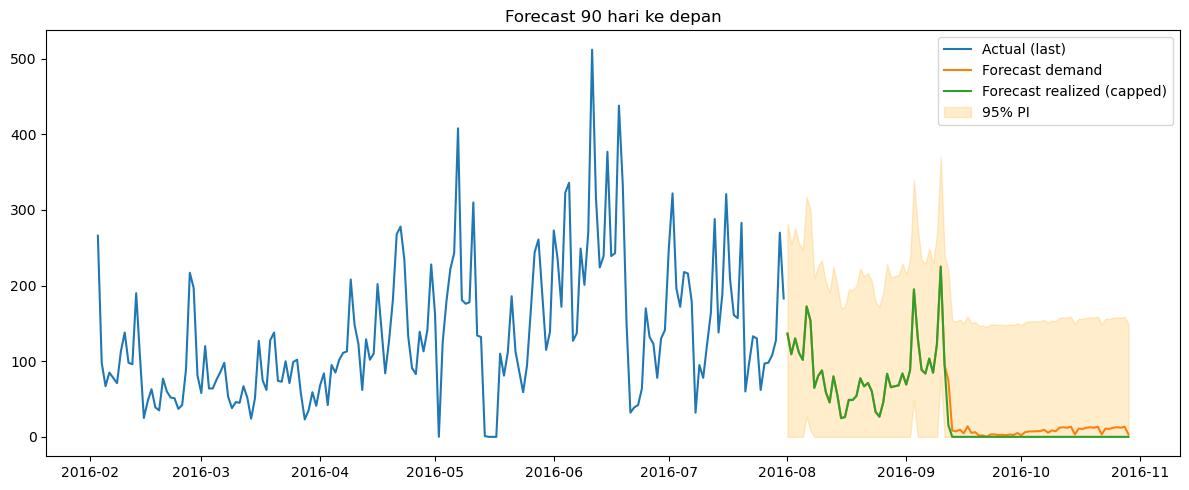

Preview Tabel Forecast (15 hari pertama):


,yhat_demand,y_realized,yhat_low,yhat_high,stock_eod
date,,,,,
2016-08-01,136.54,136.54,0.00,281.98,3505.46
2016-08-02,109.19,109.19,0.00,254.63,3396.27
2016-08-03,130.23,130.23,0.00,275.67,3266.05
2016-08-04,111.06,111.06,0.00,256.50,3154.99
2016-08-05,101.75,101.75,0.00,247.20,3053.23
2016-08-06,172.47,172.47,27.03,317.91,2880.76
2016-08-07,153.71,153.71,8.26,299.15,2727.06
2016-08-08,64.78,64.78,0.00,210.22,2662.28
2016-08-09,80.53,80.53,0.00,225.98,2581.75


In [36]:
# 8) Visualisasi Forecast

lookback = min(180, len(df))
plt.figure(figsize=(12,5))
plt.plot(df.index[-lookback:], df['sales'].iloc[-lookback:], label='Actual (last)')
if not fore_df.empty:
    plt.plot(fore_df.index, fore_df['yhat_demand'], label='Forecast demand', color='tab:orange')
    plt.plot(fore_df.index, fore_df['y_realized'], label='Forecast realized (capped)', color='tab:green')
    if {'yhat_low','yhat_high'}.issubset(fore_df.columns):
        plt.fill_between(fore_df.index, fore_df['yhat_low'], fore_df['yhat_high'], color='orange', alpha=0.2, label='95% PI')
plt.title(f'Forecast {FORECAST_HORIZON} hari ke depan')
plt.legend(); plt.tight_layout(); plt.show()

# Tabel ringkas 15 hari pertama
if not fore_df.empty:
    cols = ['yhat_demand','y_realized','stock_eod']
    if {'yhat_low','yhat_high'}.issubset(fore_df.columns):
        cols = ['yhat_demand','y_realized','yhat_low','yhat_high','stock_eod']
    print("Preview Tabel Forecast (15 hari pertama):")
    display(fore_df[cols].head(15).round(2))

### Interpretasi Visual

Grafik di atas merangkum seluruh temuan dari analisis ini ke dalam satu visual yang bercerita. Grafik ini tidak hanya menampilkan angka, tetapi juga memberikan **peringatan strategis** yang jelas mengenai kondisi inventaris di masa depan.

### Analisis Grafik
* **Konteks Historis (Garis Biru):** Kita dapat melihat bahwa penjualan historis bersifat sangat volatil, dengan beberapa puncak dan lembah yang signifikan.
* **Proyeksi Masa Depan (Garis Oranye & Hijau):** Model memproyeksikan adanya lonjakan permintaan yang besar pada awal September. Awalnya, stok diperkirakan cukup untuk memenuhi permintaan ini.
* **Momen Kritis (Pertengahan September):** Titik paling krusial dalam grafik adalah saat **garis hijau (`Forecast realized`) jatuh drastis ke nol**. Ini adalah visualisasi dari **prediksi STOCKOUT**. Lonjakan permintaan sebelumnya diprediksi akan menguras habis seluruh inventaris.
* **Area Ketidakpastian (Area Oranye):** Area yang melebar di sekitar lonjakan permintaan menunjukkan adanya risiko dan ketidakpastian yang tinggi pada periode tersebut.

## 9) Analitik Persediaan: DOH, Turnover, dan Reorder Point
- DOH (Days of Holding): stok / rata-rata penjualan 7 hari
- Turnover ratio: stok / penjualan (referensi kasar)
- Reorder Point (ROP) dinamis:
  - Menggunakan profil rata-rata dan deviasi penjualan per DOW selama lead time
  - ROP = μ_L + z · σ_L, dengan z dari service level

Kita juga menampilkan proyeksi stok ke depan dibanding ROP hari ini

Ringkasan DOH & Turnover (5 hari terakhir historis):


,stock,sales,DOH,turnover_ratio
date,,,,
2016-07-27,3179.0,98.0,32.821534,32.438776
2016-07-28,3071.0,108.0,29.610193,28.435185
2016-07-29,4095.0,128.0,37.916667,31.992188
2016-07-30,3825.0,270.0,29.983203,14.166667
2016-07-31,3642.0,183.0,26.949260,19.901639


Dynamic ROP (mulai 2016-07-31, LT=7 hari, SL=95%):
  μ_L=821.2, σ_L=226.1, z=1.65 -> ROP=1194.2 unit
Stok saat ini=3642.0 vs ROP=1194.2 -> Risiko stockout: rendah
ROP Weekday≈1069.8 | ROP Weekend≈1510.1 (LT=7 hari, SL=95%)


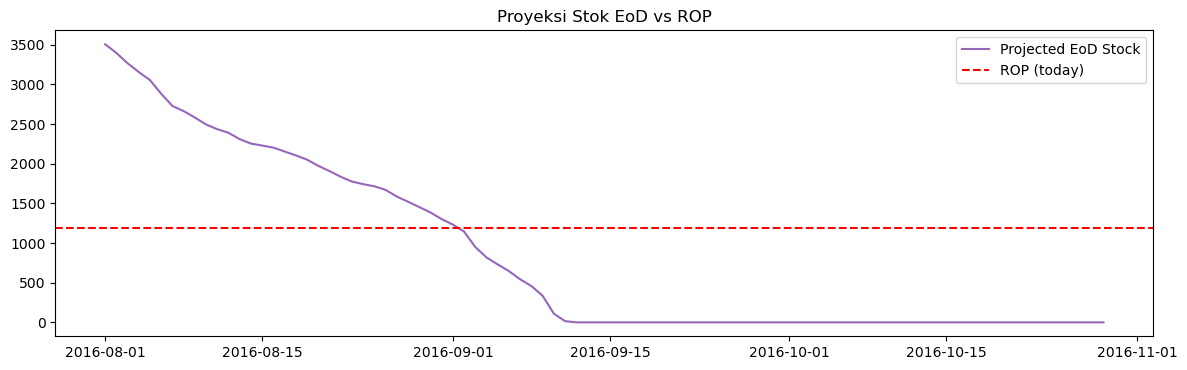

In [39]:
# 9) Analitik Persediaan

inv = df.copy()
avg7 = inv['sales'].rolling(7, min_periods=1).mean().replace(0, np.nan)
inv['DOH'] = (inv['stock'] / avg7).replace([np.inf,-np.inf], np.nan)
inv['turnover_ratio'] = (inv['stock'] / inv['sales'].replace(0, np.nan)).replace([np.inf,-np.inf], np.nan)

print("Ringkasan DOH & Turnover (5 hari terakhir historis):")
display(inv[['stock','sales','DOH','turnover_ratio']].tail())

# ROP dinamis berbasis DOW
hist = df.last('365D') if len(df) > 365 else df.copy()
dow_stats = hist.groupby(hist.index.dayofweek)['sales'].agg(['mean','std']).rename_axis('dow')

def dynamic_rop(start_date, L=LEAD_TIME_DAYS, z=Z):
    days = pd.date_range(start_date + pd.Timedelta(days=1), periods=L, freq='D')
    mu = 0.0; var = 0.0
    for d in days:
        st = dow_stats.loc[d.dayofweek]
        mu += float(st['mean'] if not np.isnan(st['mean']) else 0.0)
        std = float(st['std'] if not np.isnan(st['std']) else 0.0)
        var += std**2
    sigma = np.sqrt(var)
    rop = mu + z * sigma
    return rop, mu, sigma

today = df.index[-1]
rop_today, muL, sigmaL = dynamic_rop(today, LEAD_TIME_DAYS, Z)
stock_today = float(df['stock'].iloc[-1])
risk_flag = stock_today < rop_today

print(f"Dynamic ROP (mulai {today.date()}, LT={LEAD_TIME_DAYS} hari, SL={int(SERVICE_LEVEL*100)}%):")
print(f"  μ_L={muL:.1f}, σ_L={sigmaL:.1f}, z={Z} -> ROP={rop_today:.1f} unit")
print(f"Stok saat ini={stock_today:.1f} vs ROP={rop_today:.1f} -> Risiko stockout: {'TINGGI' if risk_flag else 'rendah'}")

# ROP Weekday vs Weekend (referensi kasar)
wd = hist[hist.index.dayofweek < 5]['sales']
we = hist[hist.index.dayofweek >= 5]['sales']
wd_mean, we_mean = wd.mean(), we.mean()
wd_std,  we_std  = wd.std(ddof=1), we.std(ddof=1)

def rop_static_by_daytype(L=LEAD_TIME_DAYS, z=Z):
    mu_wd = L * (0.0 if np.isnan(wd_mean) else wd_mean)
    mu_we = L * (0.0 if np.isnan(we_mean) else we_mean)
    sigma_wd = np.sqrt(L) * (0.0 if np.isnan(wd_std) else wd_std)
    sigma_we = np.sqrt(L) * (0.0 if np.isnan(we_std) else we_std)
    return (mu_wd + z*sigma_wd, mu_we + z*sigma_we)

rop_wd, rop_we = rop_static_by_daytype()
print(f"ROP Weekday≈{rop_wd:.1f} | ROP Weekend≈{rop_we:.1f} (LT={LEAD_TIME_DAYS} hari, SL={int(SERVICE_LEVEL*100)}%)")

# Visualisasi proyeksi stok vs ROP
if not fore_df.empty:
    plt.figure(figsize=(12,3.8))
    plt.plot(fore_df.index, fore_df['stock_eod'], label='Projected EoD Stock', color='tab:purple')
    plt.axhline(rop_today, color='r', ls='--', label='ROP (today)')
    plt.title('Proyeksi Stok EoD vs ROP')
    plt.legend(); plt.tight_layout(); plt.show()

### Analisis Persediaan dan Rekomendasi Pemesanan

Tahap terakhir ini adalah jembatan antara peramalan (*forecasting*) dan tindakan nyata di bagian operasional. Kami menggunakan hasil prediksi untuk menghitung metrik-metrik kunci persediaan yang memberikan jawaban atas pertanyaan "Kapan dan berapa banyak harus memesan ulang?".

### Kesehatan Inventaris Saat Ini
* **DOH & Turnover:** Tabel ringkasan historis menunjukkan kesehatan inventaris dalam 5 hari terakhir. DOH sekitar **27-38 hari** mengindikasikan bahwa stok saat ini cukup tebal.
* **Reorder Point (ROP):** Titik Pemesanan Ulang yang dinamis dihitung sebesar **~1194 unit**. Dengan stok saat ini sebesar **3642 unit**, kita berada jauh di atas ambang batas aman, sehingga **tidak perlu ada pemesanan segera**.

### Proyeksi dan Titik Aksi
Grafik "Proyeksi Stok EoD vs ROP" memberikan insight yang paling penting:

* **Visualisasi Risiko:** Grafik ini secara visual memetakan proyeksi penurunan stok (garis ungu) terhadap batas aman ROP (garis merah).
* **Waktu untuk Bertindak:** Titik di mana garis proyeksi stok bersilangan dengan garis ROP adalah **sinyal untuk melakukan pemesanan ulang**. Proyeksi menunjukkan momen ini akan terjadi sekitar **minggu pertama bulan September**.

### Kesimpulan Akhir & Rekomendasi
Meskipun kondisi stok saat ini aman, analisis peramalan dan persediaan secara kolektif memberikan **peringatan dini yang jelas**. Untuk menghindari kehabisan stok (*stockout*) yang diproyeksikan terjadi pada pertengahan September, **rekomendasi utamanya adalah untuk menjadwalkan pemesanan ulang (replenishment) pada atau sebelum minggu pertama bulan September**.

Analisis ini telah mengubah data mentah menjadi sebuah *roadmap* operasional yang dapat ditindaklanjuti.